##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Boosted trees using Estimators

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/estimator/boosted_trees"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/estimator/boosted_trees.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/estimator/boosted_trees.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/estimator/boosted_trees.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an end-to-end walkthrough of training a Gradient Boosting  model using decision trees with the `tf.estimator` API. Boosted Trees models are among the most popular and effective machine learning approaches for both regression and classification. It is an ensemble technique that combines the predictions from several (think 10s, 100s or even 1000s) tree models.

Boosted Trees models are popular with many machine learning practitioners as they can achieve impressive performance with minimal hyperparameter tuning.

## Load the titanic dataset
You will be using the titanic dataset, where the (rather morbid) goal is to predict passenger survival, given characteristics such as gender, age, class, etc.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [12]:
import tensorflow as tf
import tensorflow.feature_column as fc 
tf.random.set_seed(123)
tf.__version__

'2.2.0'

The dataset consists of a training set and an evaluation set:

* `dftrain` and `y_train` are the *training set*—the data the model uses to learn.
* The model is tested against the *eval set*, `dfeval`, and `y_eval`.

For training you will use the following features:


<table>
  <tr>
    <th>Feature Name</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>sex</td>
    <td>Gender of passenger</td>
  </tr>
  <tr>
    <td>age</td>
    <td>Age of passenger</td>
  </tr>
    <tr>
    <td>n_siblings_spouses</td>
    <td>siblings and partners aboard</td>
  </tr>
    <tr>
    <td>parch</td>
    <td>of parents and children aboard</td>
  </tr>
    <tr>
    <td>fare</td>
    <td>Fare passenger paid.</td>
  </tr>
    <tr>
    <td>class</td>
    <td>Passenger's class on ship</td>
  </tr>
    <tr>
    <td>deck</td>
    <td>Which deck passenger was on</td>
  </tr>
    <tr>
    <td>embark_town</td>
    <td>Which town passenger embarked from</td>
  </tr>
    <tr>
    <td>alone</td>
    <td>If passenger was alone</td>
  </tr>
</table>

## Explore the data

Let's first preview some of the data and create summary statistics on the training set.

In [4]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


There are 627 and 264 examples in the training and evaluation sets, respectively.

In [6]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

The majority of passengers are in their 20's and 30's.

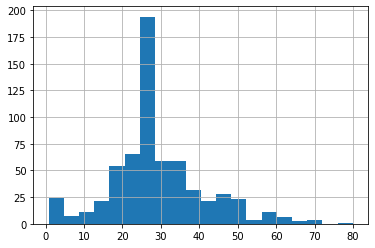

In [7]:
dftrain.age.hist(bins=20)
plt.show()

There are approximately twice as male passengers as female passengers aboard.

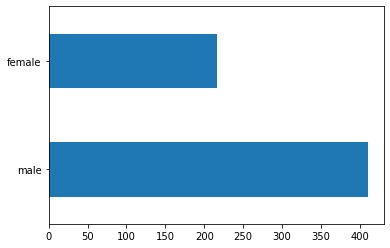

In [8]:
dftrain.sex.value_counts().plot(kind='barh')
plt.show()

The majority of passengers were in the "third" class.

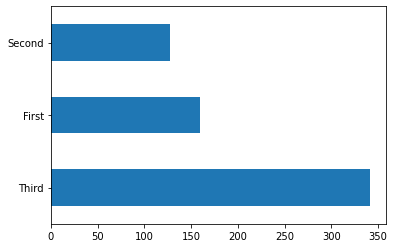

In [9]:
dftrain['class'].value_counts().plot(kind='barh')
plt.show()

Most passengers embarked from Southampton.

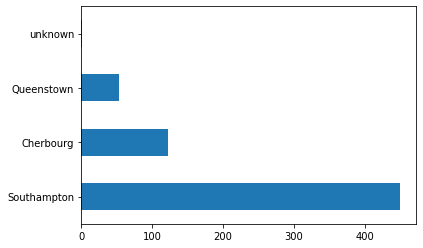

In [10]:
dftrain['embark_town'].value_counts().plot(kind='barh')
plt.show()

Females have a much higher chance of surviving vs. males. This will clearly be a predictive feature for the model.

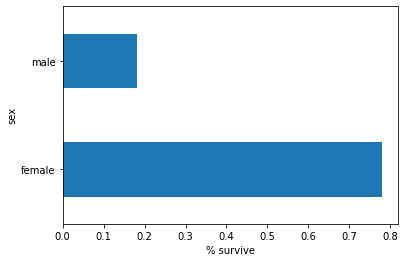

In [11]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
plt.show()

## Create feature columns and input functions
The Gradient Boosting estimator can utilize both numeric and categorical features. Feature columns work with all TensorFlow estimators and their purpose is to define the features used for modeling. Additionally they provide some feature engineering capabilities like one-hot-encoding, normalization, and bucketization. In this tutorial, the fields in `CATEGORICAL_COLUMNS` are transformed from categorical columns to one-hot-encoded columns ([indicator column](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column)):

In [13]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(fc.categorical_column_with_vocabulary_list(feature_name, vocab))

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town',

You can view the transformation that a feature column produces. For example, here is the output when using the `indicator_column` on a single example:

In [14]:
example = dict(dftrain.head(1))
class_fc = fc.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


Additionally, you can view all of the feature column transformations together:

In [15]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

Next you need to create the input functions. These will specify how data will be read into our model for both training and inference. You will use the `from_tensor_slices` method in the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API to read in data directly from Pandas. This is suitable for smaller, in-memory datasets. For larger datasets, the tf.data API supports a variety of file formats (including [csv](https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset)) so that you can process datasets that do not fit in memory.

In [16]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

## Train and evaluate the model

Below you will do the following steps:

1. Initialize the model, specifying the features and hyperparameters.
2. Feed the training data to the model using the `train_input_fn` and train the model using the `train` function.
3. You will assess model performance using the evaluation set—in this example, the `dfeval` DataFrame. You will verify that the predictions match the labels from the `y_eval` array.

Before training a Boosted Trees model, let's first train a linear classifier (logistic regression model). It is best practice to start with a simpler model to establish a benchmark.

In [17]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


Next let's train a Boosted Trees model. For boosted trees, regression (`BoostedTreesRegressor`) and classification (`BoostedTreesClassifier`) are supported. Since the goal is to predict a class - survive or not survive, you will use the `BoostedTreesClassifier`.


In [18]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.818182
accuracy_baseline         0.625000
auc                       0.876615
auc_precision_recall      0.857770
average_loss              0.410829
label/mean                0.375000
loss                      0.410829
precision                 0.780220
prediction/mean           0.370849
recall                    0.717172
global_step             100.000000
dtype: float64


Now you can use the train model to make predictions on a passenger from the evaluation set. TensorFlow models are optimized to make predictions on a batch, or collection, of examples at once. Earlier,  the `eval_input_fn` is  defined using the entire evaluation set.